In [4]:
%load_ext autoreload
%autoreload 2

import sys, os, multiprocessing
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import string
from hydra.model.fluo_encoder import FluoEncoder
from hydra.model.force_encoder_ecto import ForceEncoderEcto
from hydra.model.force_encoder_endo import ForceEncoderEndo
import hydra.model.helper as helper
import cmocean

import matplotlib.cbook as cbook

In [5]:
# Settings
init1 = 0
init2 = 123
# STIM_FAST = [init1, init1 + 4.75, init1 + 7.75, init1 + 9.25, init1 + 13.75, init1 + 17.5, init1 + 21.5, init1 + 24.5, init1 + 30,
#              init2, init2 + 4.25, init2 + 7, init2 + 8.75, init2 + 11.5, init2 + 13.25, init2 + 17, init2 + 18.75, init2 + 22.75, init2 + 27, init2 + 29.25]
STIM_FAST = [init1+0.0, init1+9.25, init1+14.5, init1+18.25, init1+21.5, init1+24.5, init1+28.0, init1+31.5, init1+35.25, init1+40.5,
             init2+0.0, init2+7.75, init2+15.25, init2+19.75, init2+23.0, init2+27.25, init2+30.5, init2+34.25, init2+38.25, init2+43.5]
STIM_SLOW = [init1+15, init2+15]
DUR_FAST = 0.01
DUR_SLOW = 4
TIME = np.arange(0, 250, 0.02)
MOMENTS = [100.04, 100.15, 120, 150, 100+init2+0.04, 100+init2+0.15, 100+init2+15, 100+init2+45]
T = 200
DT = 0.02

In [6]:
# Load neuronal fluorescence
fluo = pd.read_csv('./results/data/fluorescence/total_fluo_Pre_Bisect_40x_4fps_ex3.csv').values
fluo = fluo[2535:3555]
fluo = helper.normalize(fluo)

In [7]:
# Load calcium
FILENAME = "2020-08-14-22-39-05-658838"
CALCIUM = pd.read_hdf("./results/data/calcium/" + FILENAME + ".h5")
CALCIUM = CALCIUM.values.reshape(len(CALCIUM), 60, 60)
ca_ecto_full = CALCIUM[:, :30, :]
ca_endo_full = CALCIUM[:, 30:, :]
CA_ECTO = CALCIUM[5000:, :30, :]
CA_ENDO = CALCIUM[5000:, 30:, :]

In [8]:
# Average [Ca2+]
ca_ecto_avg = np.mean(np.mean(CA_ECTO, axis=1), axis=1)
ca_endo_avg = np.mean(np.mean(CA_ENDO, axis=1), axis=1)

In [9]:
# Encode fluorescence
fluo_encoder = FluoEncoder(ca_ecto_avg, T=250, dt=0.02)
fluo_ecto = fluo_encoder.step()
fluo_ecto = (fluo_ecto - min(fluo_ecto))/(max(fluo_ecto) - min(fluo_ecto))

fluo_encoder = FluoEncoder(ca_endo_avg, T=250, dt=0.02)
fluo_endo = fluo_encoder.step()
fluo_endo = (fluo_endo - min(fluo_endo))/(max(fluo_endo) - min(fluo_endo))

In [10]:
# Encode force
fo_ecto = helper.encode_force_2d(ForceEncoderEcto, ca_ecto_full, 30, 60, 0.02, save_interval=1)[5000:]
fo_endo = helper.encode_force_2d(ForceEncoderEndo, ca_endo_full, 30, 60, 0.02, save_interval=1)[5000:]
fo_ecto_avg = np.mean(np.mean(fo_ecto, axis=1), axis=1)
fo_endo_avg = np.mean(np.mean(fo_endo, axis=1), axis=1)
FORCE = np.concatenate((fo_ecto, fo_endo), axis=1)

100%|██████████| 17500/17500 [00:07<00:00, 2243.51it/s]


In [11]:
# Load model length data
lengths = helper.length_of_model("./results/data/length/coords_658838_k7c03n001_rlx80.txt", display=False, totaltime=350)

In [12]:
# Load real length data
real_lengths = pd.read_csv("./results/data/length/lengths_Pre_Bisect_40x_4fps_ex3.csv").values
real_lengths = [x*(0.227/40) for x in real_lengths]
real_lengths = real_lengths[2550:3550]

In [13]:
# Load images
images = []
imagefiles = ['behavior_0s.png', 'behavior_10s.png', 'behavior_20s.png', 'behavior_50s.png', 
              'behavior_95s.png', 'behavior_105s.png', 'behavior_145s.png', 'behavior_199s.png']

for imagefile in imagefiles:
    with cbook.get_sample_data('/home/hengji/Documents/hydra/hydra/results/figures/behaviors/' + imagefile) as image_file:
        images.append(plt.imread(image_file))

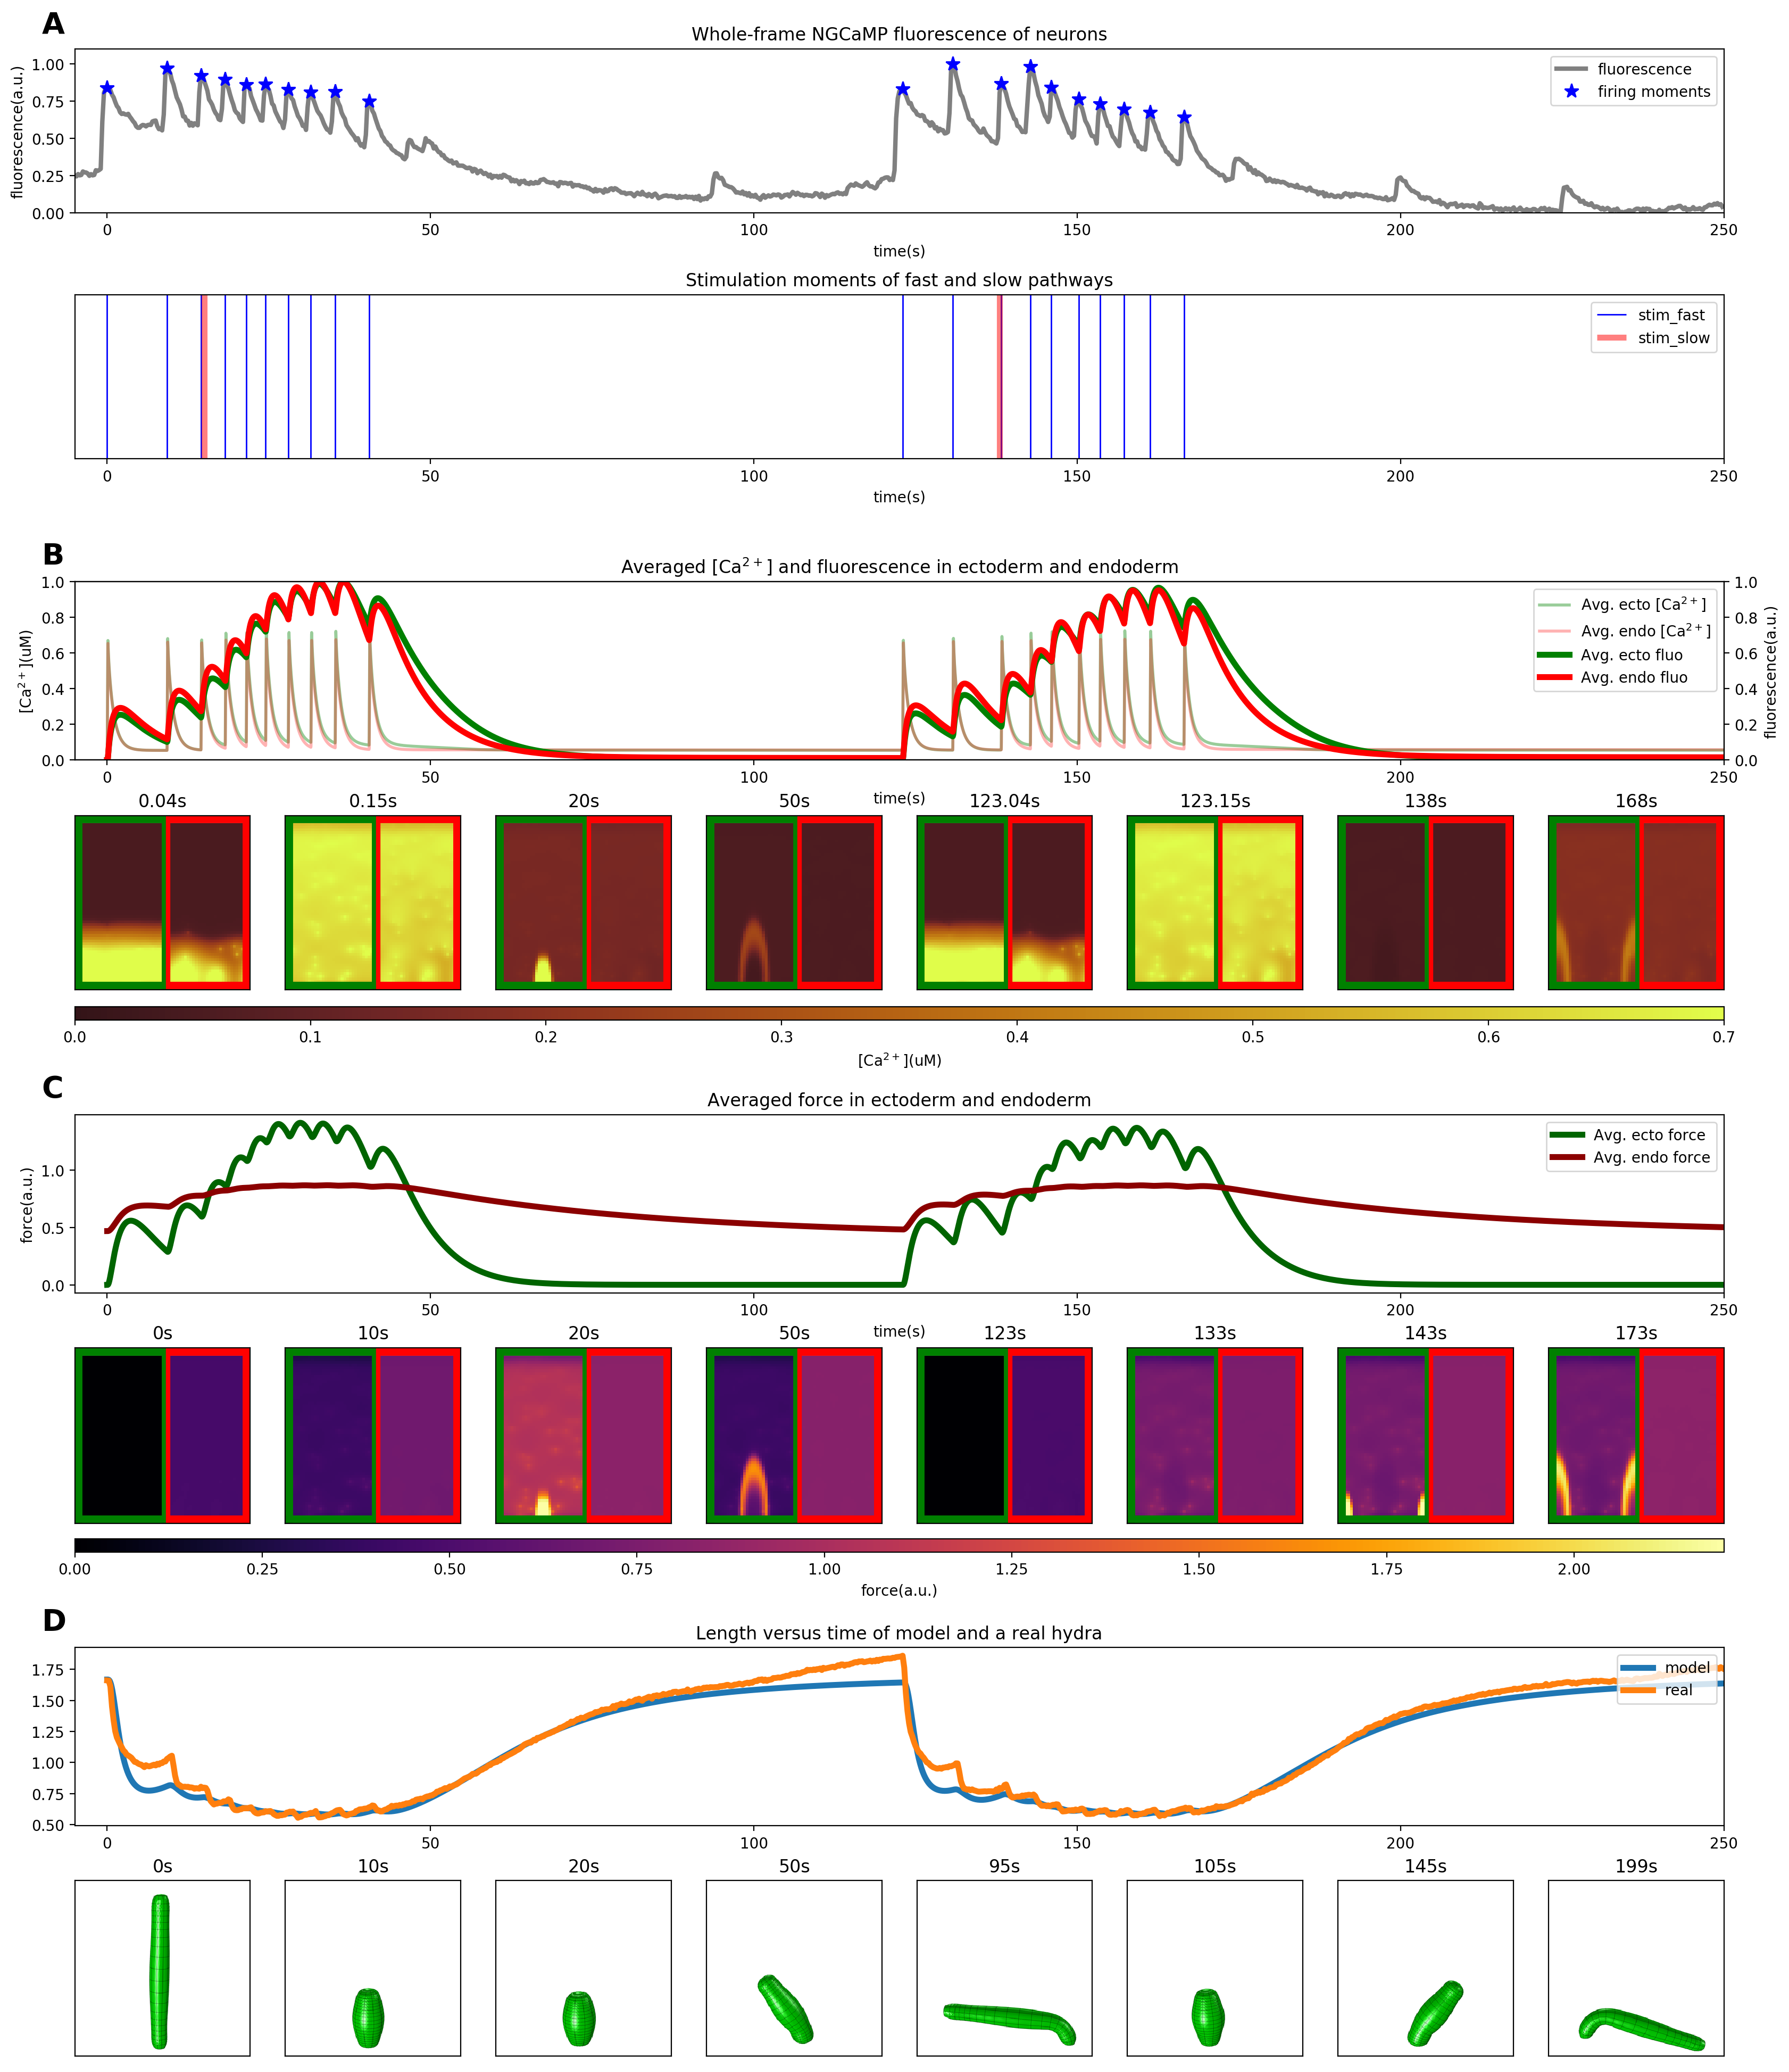

In [14]:
NUMX = 30
NUMY = 60

fig = plt.figure(figsize=(20,25), dpi=200)

# Add axes
gs = gridspec.GridSpec(4, 1, height_ratios=[2, 2, 2, 2])
gs.update(hspace=0.3)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[0], hspace=0.5)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[1], hspace=0.3)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[2], hspace=0.3)
gs3 = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[3], hspace=0.3)

axs0 = [plt.subplot(gs0[0, :])]
axs1 = [plt.subplot(gs1[0, :])]
axs2 = [plt.subplot(gs2[0, :])]
axs3 = [plt.subplot(gs3[0, :])]

axs0.append(plt.subplot(gs0[1, :]))

axs_all = [axs0, axs1, axs2, axs3]
gs_all = [gs0, gs1, gs2, gs3]

for j in range(8):
    for k in range(1, 4):
        axs_all[k].append(plt.subplot(gs_all[k][1, j]))
    
# Annotate the figures
for k in range(4):
    ax = axs_all[k][0]
    ax.text(-0.02, 1.1, string.ascii_uppercase[k], transform=ax.transAxes, 
            size=20, weight='bold')

# Draw Subplot A (top)
ax = axs0[0]

lns1 = ax.plot(np.arange(-5, 250, 0.25), fluo, 'gray', linewidth=3, label='fluorescence')

for stim in STIM_FAST:
    lns2 = ax.plot(stim, fluo[int((stim+5)/0.25)], marker="*", color='b', markersize=10, label='firing moments', linestyle='None')

ax.set_xlim(-5, 250)
ax.set_ylim(0, 1.1)
ax.set_xlabel('time(s)')
ax.set_ylabel('fluorescence(a.u.)')
ax.set_title('Whole-frame NGCaMP fluorescence of neurons')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)


# Draw Subplot A (bottom)
ax = axs0[1]
for j, moment in enumerate(STIM_FAST):
    if j == 0:
        ax.vlines(moment, 0, 1, color='b', linewidth=1, label='stim_fast')
    else:
        ax.vlines(moment, 0, 1, color='b', linewidth=1)
    
for j, moment in enumerate(STIM_SLOW):
    if j == 0:
        ax.vlines(moment, 0, 1, color='r', alpha=0.5, linewidth=4, label='stim_slow')
    else:
        ax.vlines(moment, 0, 1, color='r', alpha=0.5, linewidth=4)
ax.set_xlim(-5, 250)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel('time(s)')
ax.legend()
ax.set_title('Stimulation moments of fast and slow pathways')

# Draw Subplot B (top)
ax = axs1[0]
lns1 = ax.plot(TIME, ca_ecto_avg, color='green', linestyle='-', 
        alpha=0.4, linewidth=2, label='Avg. ecto [Ca$^{2+}$]')
lns2 = ax.plot(TIME, ca_endo_avg, color='red', linestyle='-', 
        alpha=0.3, linewidth=2, label='Avg. endo [Ca$^{2+}$]')
ax.set_xlim(-5, 250)
ax.set_ylim(0, 1)
ax.set_xlabel('time(s)')
ax.set_ylabel('[Ca$^{2+}$](uM)')

ax_ = ax.twinx()
lns3 = ax_.plot(TIME, fluo_ecto, color='green', linestyle='-', 
         linewidth=4, label='Avg. ecto fluo')
lns4 = ax_.plot(TIME, fluo_endo, color='red', linestyle='-', 
         linewidth=4, label='Avg. endo fluo')
ax_.set_ylim(0, 1)
ax_.set_ylabel('fluorescence(a.u.)')

lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.set_title('Averaged [Ca$^{2+}$] and fluorescence in ectoderm and endoderm')

# Draw Subplot B (bottom)
for j, ax in enumerate(axs1[1:]):
    im = ax.imshow(CALCIUM[int(MOMENTS[j]/DT)].T, 
              cmap=cmocean.cm.solar, vmin=0, vmax=0.7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(round(MOMENTS[j]- 100, 2)) + 's')
    ax.axhline(-0.5, 0, 0.5, color='green', linewidth=5)
    ax.axhline(NUMY+1, 0, 0.5, color='green', linewidth=5)
    ax.axhline(-0.5, 0.52, 1, color='red', linewidth=5)
    ax.axhline(NUMY+1, 0.52, 1, color='red', linewidth=5)
    ax.axvline(-1.5, 0, 1, color='green', linewidth=5)
    ax.axvline(NUMX*2+0.5, 0, 1, color='red', linewidth=5)
    ax.axvline(NUMX+0.5, 0, 1, color='green', linewidth=5)
    ax.axvline(NUMX+1.5, 0, 1, color='red', linewidth=3)
    ax.set_xlim(-3, NUMX*2+2)
    ax.set_ylim(-2, NUMY+2.5)

    
position = fig.add_axes([0.125, 0.565-0.05, 0.775, 0.005])
cb = plt.colorbar(im, cax=position, orientation='horizontal')
cb.set_label('[Ca$^{2+}$](uM)')

# Draw Subplot C (top)
ax = axs2[0]
ax.plot(TIME, fo_ecto_avg, color='darkgreen', linestyle='-',
        linewidth=4, label='Avg. ecto force')
ax.plot(TIME, fo_endo_avg, color='darkred', linestyle='-', 
        linewidth=4, label='Avg. endo force')
ax.set_xlabel('time(s)')
ax.set_ylabel('force(a.u.)')
ax.set_xlim(-5, 250)
ax.set_title("Averaged force in ectoderm and endoderm")
ax.legend()

# Draw Subplot C (bottom)
MOMENTS_FORCE = [0, 10, 20, 50, init2, init2+10, init2+20, init2+50]

for j, ax in enumerate(axs2[1:]):
    im = ax.imshow(FORCE[int((MOMENTS_FORCE[j])/DT)].T, 
              cmap='inferno', vmin=0, vmax=2.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(round(MOMENTS_FORCE[j], 2)) + 's')
    ax.axhline(-1, 0, 0.5, color='green', linewidth=5)
    ax.axhline(NUMY+1, 0, 0.5, color='green', linewidth=5)
    ax.axhline(-1, 0.52, 1, color='red', linewidth=5)
    ax.axhline(NUMY+1, 0.52, 1, color='red', linewidth=5)
    ax.axvline(-1.5, 0, 1, color='green', linewidth=5)
    ax.axvline(NUMX*2+0.5, 0, 1, color='red', linewidth=5)
    ax.axvline(NUMX+0.5, 0, 1, color='green', linewidth=5)
    ax.axvline(NUMX+1.5, 0, 1, color='red', linewidth=3)
    ax.set_xlim(-3, NUMX*2+2)
    ax.set_ylim(-2.5, NUMY+2.5)

position = fig.add_axes([0.125, 0.343-0.028, 0.775, 0.005])
cb = plt.colorbar(im, cax=position, orientation='horizontal')
cb.set_label('force(a.u.)')

# Draw Subplot D (top)
ax = axs3[0]
ax.plot(np.arange(0, 250.1, 0.1), lengths[:2501], linewidth=4, label='model')
# ax.plot(np.arange(0, 100.1, 0.1), lengths, linewidth=4, label='model')
ax.plot(np.arange(0, 250, 0.25), real_lengths, linewidth=4, label='real')
ax.set_xlim(-5, 250)
ax.legend(loc='upper right')
ax.set_title('Length versus time of model and a real hydra')

# Draw Subplot D (bottom)
MOMENTS_BEHAV = [0, 10, 20, 50, 95, 105, 145, 199]
for j, ax in enumerate(axs3[1:]):
    im = images[j]
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(round(MOMENTS_BEHAV[j], 2)) + 's')

plt.savefig('./results/figures/simulate-cycles.png', bbox_inches='tight')
plt.show()